# X entiment Analysis

## Introduction
Sentiment analysis is a technique used to determine the emotional tone from remarks or comments that users of certain application either X, facebook, instagram or tiktok about a certain topic.

This remarks can have a positive tone, neutral tone and negative tone towards a certain audience.



## Business Understanding
### Background
X is a popular social media platform that most people use to share their opinions about certain topics, this can either be political, religious or social trends.

These opinions can be positive, negative or neutral towards the topic been addressed. These opinions are mainly in text format.


### Problem statement
Due to the growing amount of user-generated content on X, it is becoming more difficult for researchers, corporation to accurately and efficiently gauge public opinion on particular subjects, goods, or occasions. It's challenging to glean useful data from tweets because of their sheer number and informal style, which frequently includes slang, acronyms, and emoticons. This leads to inadequate insights generated by corporations from public opinion to improve certain products or when advertising certain products.

### Objective
1. Develop a sentiment analysis model that uses natural preprocessing language(nlp) to preprocess and clean the tweets, and make it in a more structured format for sentiment analysis.

2. Use the sentiment analysis model that can accurately classify tweets into positive, negative and neutral sentiment categories.

3. Evaluate Performance: Measure the model's accuracy, precision, recall, and F1-score on a labeled dataset, and iteratively improve based on evaluation results.

### Conclusion
Although emojis, acronyms, and slang are common on Twitter, the informal tone of the network makes it difficult to draw meaningful conclusions from user-generated content. While sophisticated NLP models and neural network approaches, handle the complexity of sentiment grouping, preprocessing is essential to cleanse this noisy data.









## Import Libraries

In [41]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install datasets

## Loading the data

In [3]:
from datasets import load_dataset

ds = load_dataset("mteb/tweet_sentiment_extraction")

In [4]:
dataset = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
train_data = dataset['train']
# Convert the dataset to a DataFrame
train_df = pd.DataFrame(train_data)

train_df.head(20)

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,1,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,2,positive
7,50e14c0bb8,Soooo high,1,neutral
8,e050245fbd,Both of you,1,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,2,positive


In [8]:
# checking the columns
train_df.columns

Index(['id', 'text', 'label', 'label_text'], dtype='object')

In [10]:
# size of the dataframe
train_df.shape

(27481, 4)

In [11]:
# preview a text
train_df['text'][1500]

'This wind is crampin` my style. I have a section of my yard that won`t get any water. I`d move the sprinkler, but it`s surrounded by mud.'

In [12]:
# value counts of the sentiments
train_df['label_text'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: label_text, dtype: int64

In [13]:
# summary information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          27481 non-null  object
 1   text        27481 non-null  object
 2   label       27481 non-null  int64 
 3   label_text  27481 non-null  object
dtypes: int64(1), object(3)
memory usage: 858.9+ KB


## Handling Missing Values

We want to ensure there are no missing tweets or sentiment labels in the dataset before preprocessing.

In [16]:
# Checking for missing values
missing_values = train_df.isnull().sum()
if missing_values.sum() == 0:
    print('There are no missing values')
else:
    print('Check for the missing values')

There are no missing values


## Class Distribution

A bar plot showing the distribution of classes (negative, neutral, positive) can give us insight into whether our dataset is balanced or imbalanced.

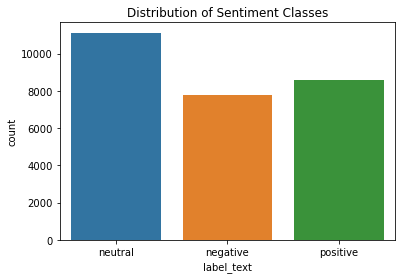

In [42]:
# Plot class distribution
sns.countplot(x='label_text', data=train_df)
plt.title('Distribution of Sentiment Classes')
plt.show()

It shows that the neutral class is the most common sentiment in our dataset, followed by negative and positive sentiments.

## Text Preprocessing

In [19]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# display stopwords
print(stop_words)

{'all', 'will', 'needn', 'mightn', 'under', 'll', 'same', 'you', 'my', 've', 'ma', "she's", "isn't", 'a', 'been', 'no', 'haven', 'at', 'after', 'yourself', 'then', 'from', 'be', 'your', 'himself', 'an', 'those', 'in', 'such', 'm', 'he', 'own', 'by', 'once', 're', 'other', 'between', 'some', 'mustn', 'weren', 'on', 'before', 's', 'o', 'didn', "shan't", 'now', 'out', 'that', "didn't", 'herself', "mightn't", 'hasn', 'me', 'ain', 'isn', 'how', 'don', 'or', 'are', 'any', 'doing', 'ourselves', 'can', 'up', 'wasn', 'each', 'their', 'few', 'is', "needn't", 'during', 'where', 'the', "it's", 'further', 'themselves', 'wouldn', 'nor', 'only', 'whom', 'but', 'below', 'very', "doesn't", 'have', 'i', 'won', 'of', 'its', "won't", 'doesn', 'because', 'him', 'above', "hadn't", 'do', 'yourselves', "mustn't", "shouldn't", "haven't", "aren't", 'off', 'than', 'as', 't', 'yours', 'shan', "hasn't", "wasn't", 'hers', 'until', 'for', 'itself', 'just', 'against', "couldn't", 'why', 'them', 'were', 'ours', 'they'

In [23]:
def preprocess_text(text) -> str:
  """
  Function to clean and preprocess the text
  """
  # lower case
  text = text.lower()
  # remove html tags
  text = re.sub(r'<.*?>', '', text)
  # remove non-alphabetical
  text = re.sub(r'[^a-z\s]', '', text)
  # remove stop words
  text = ' '.join([word for word in text.split() if word not in stop_words])
  # remove mentions
  text = re.sub(r'@\w+', '', text)
  # remove html links
  text = re.sub(r'http\S+|www.\S+', '', text)

  return text

In [24]:
# apply to the text column
train_df['text'] = train_df['text'].apply(preprocess_text)

In [25]:
# preview a text after preprocessing
train_df['text'][1500]

'wind crampin style section yard wont get water id move sprinkler surrounded mud'

## Tokenization and Padding

In [31]:
# tokenize the 'text' column
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
print(f'Vocabulary size: {len(word_index)}')

Vocabulary size: 26517


In [32]:
# Convert texts to sequences
X = tokenizer.texts_to_sequences(train_df['text'])

In [33]:
# Defining a max length for truncating the sequences.
max_len = 500
X = pad_sequences(X, maxlen=max_len)

In [35]:
# Extract the target labels (sentiment) from the 'label' column in the dataset
# This will be used as the dependent variable.
y = train_df['label'].values

## Distribution of Sequence Lengths

After padding, we check the distribution of the lengths of sequences (the number of tokens per sample).This helps ensure that our padding or truncation strategy is appropriate.

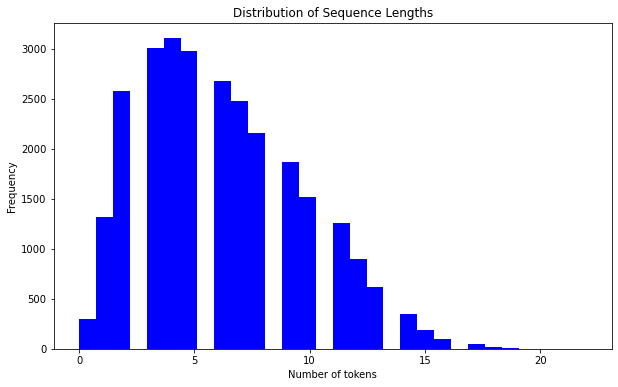

In [38]:
# Get the length of each sequence (before padding)
seq_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train_df['text'])]

# Plot distribution of sequence lengths
plt.figure(figsize=(10,6))
plt.hist(seq_lengths, bins=30, color='blue')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.show()

The distribution plot of sequence lengths shows that the majority of text samples have between 2 and 10 tokens, with a peak around 4-6 tokens. The distribution tail suggests that some samples have longer sequences, though fewer of them exceed 15 tokens.